In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.colors import LinearSegmentedColormap
import os

In [74]:
# choose basa or GG
database = 'GG' # 'basa' or 'GG'

if database == 'basa':
    results = 'results_basa'
    data_species = 'GAM_species/species_fit_140_0.01.pkl'
    windows = [(0, 40), (20, 60), (40, 80), (60, 100), (80, 120), (100, 140)]
    windows = [(0, 50), (51, 84), (85, 140)]

if database == 'GG':
    results = 'results_GG'
    data_species = '../data_GG/GAM/species_fit_301_0.01.pkl'
    windows = [(0, 100), (50, 150), (100, 200), (150, 250), (200, 300)]
    windows = [(150, 199), (200, 249)]
    windows = [(0, 56), (57, 149), (150, 249), (250, 300)]



species_index = pd.read_pickle(f'{results}/species_index.pkl')
species_index_T = pd.Series(species_index)
species_index_T = pd.Series(species_index_T.index, index = species_index_T.values)
species_index_T = species_index_T.to_dict()

if database == 'basa':
    species_index_non_aq = {k: v for k, v in species_index.items()}
    species_index_T_non_aq = {v: k for k, v in species_index_non_aq.items()}
    non_aq_species = list(species_index_non_aq.keys())
if database == 'GG':
    # ONLY NON AQUATIC SPECIES
    non_aq_species = 'Alchemilla,Chenopodiaceae,Artemisia,Cichoroideae,Asteroideae,Carduus,Asteraceae,Vernonia,Polygonum,Tribulus,Galium,Brassicaceae,Caryophylaceae,Swertia,Senecio,Erica,Hypericum,Anthospermum,Cerastium,Apiaceae,Podocarpus,Euclea,Hagenia,Juniperus,Myrsine,Rapanea,Rosa,Schefflera,Brucea,Sapotaceae,Iridaceae,Anthyllis,Maytenus,Buxus,Psydrax,Celastraceae,Celtis,Dodonaea,Ekebergia,Ephedra,Clematis,Myrica,Hypoestes,Ziziphus,Acanthus,Allophylus,Acacia,Combretum,Commiphora,Cussonia,Dobera,Lannea,Macaranga,Olea,Jasminum,Rhus,Securinega,Teclea,Zanthoxylum,Cassia,Capparidaceae,Acalypha,Euphorbia,Euphorbiacea,Phyllantus,Tamarindus,Alchornea,Aloe,Asphodellus,Leguminosae,Rubiaceae,Blepharis,Justicia,Heliotropium,Kohautia,Indigofera,Lamiaceae,Cerealia,Plantago,Planceolata,Poaceae,Rumex,Solanum,Urticaceae,Ricinus,Saussurea'.replace(' ','_').split(',')

    # species_index_non_aq = species_index
    # species_index_T_non_aq = species_index_T
    species_index_non_aq = {k: v for k, v in species_index.items() if k in set(non_aq_species)}
    species_index_T_non_aq = {v: k for k, v in species_index_non_aq.items()}



abundances = pd.read_pickle(data_species)
for species in abundances.columns:
    abundances[species]['y'][abundances[species]['y'] < 0] = 0

In [75]:
# see what's the minimum influx to set a threshold on GAM in GC

abundances_npy = np.zeros((len(abundances.columns), abundances[species]['y'].shape[0]))
for i, species in enumerate(abundances.columns):
    abundances_npy[i, :] = abundances[species]['y']
abundances_npy[abundances_npy == 0] = np.nan
pd.Series(abundances_npy.flatten()).describe()

count    2.387000e+04
mean     4.614518e+00
std      1.570462e+01
min      8.197609e-13
25%      3.033148e-07
50%      1.335713e-01
75%      8.285543e-01
max      1.032757e+02
dtype: float64

In [76]:
# plot the total abundances over time
abundances_sum = pd.DataFrame({k: v['y'] for k, v in abundances.items() if k in species_index_non_aq.keys()})
abundances_sum = abundances_sum.values.sum(axis=1)
plt.figure(figsize=(10, 5))
plt.plot(abundances_sum, label='Total abundances', color='black')
# plt.xlabel('Time')
plt.ylabel('Abundance')
plt.title('Total abundances over time')
plt.legend()

In [77]:
import networkx as nx

def read_GC_network(causality_name):
    granger_causalities = []
    granger_causalities_p_values = []
    for idx,(start,end) in enumerate(windows):
        granger_causality = pd.read_pickle(f'{results}/{causality_name}/original_table_{start}-{end}.pkl')
        granger_causality[granger_causality > 100] = 0
        granger_causality[granger_causality < -100] = 0
        # granger_causality[np.eye(granger_causality.shape[0], dtype=bool)] = np.nan
        granger_causalities.append(granger_causality)

        granger_causality_p_values = pd.read_pickle(f'{results}/{causality_name}/bootstrapped_p_values_{start}-{end}.pkl')
        granger_causality_p_values[np.eye(granger_causality_p_values.shape[0], dtype=bool)] = np.nan
        granger_causalities_p_values.append(granger_causality_p_values)
    # L = 100
    graphs = []

    for idx,(start,end) in enumerate(windows):
        
        # for the TE p_values (p_values_list) or the gc p_values (granger_causalities_p_values)
        # adjacency = p_values_list[idx]
        adjacency = granger_causalities_p_values[idx]
        # remove na from the numpy array adjacency
        adjacency = np.nan_to_num(adjacency, nan=1.0)
        # ONLY NON AQUATIC SPECIES
        species_list = list(species_index_T_non_aq.keys())

        # adjacency_non_aq = adjacency[np.ix_(species_list, species_list)]
        # cut_value = np.sort(adjacency_non_aq.flatten())[L]

        cut_value = 0.05

        adjacency_pvalued = (adjacency <= cut_value).astype(int)
        adjacency = granger_causalities[idx] * adjacency_pvalued
        
        graph = nx.from_numpy_array(adjacency, create_using=nx.DiGraph, edge_attr='weight')
        # remove all nodes that are not in the non_aq_species list
        graph.remove_nodes_from([node for node in graph.nodes() if species_index_T[node] not in non_aq_species])
        graphs.append(graph)
        print(cut_value, graph.number_of_edges())
        # explanation cause it's confusing
        # we need to create the graph with the indices of the original species index, so we use the whole adjacency matrix
        # however to remove the aquatic nodes and keep 100 links, we count them on the adjacency_non_aq, then create the whole graph, then remove again the aquatic nodes
        # this should leave about the 100 links
        
    return granger_causalities, granger_causalities_p_values, graphs

In [78]:
def read_bootstrap_GC_networks(causality_name):
    bootstrap_dir = f'{results}/{causality_name}'

    nbootstraps = 1000

    original_table = []
    bootstrapped_p_values = []

    for idx,(start,end) in enumerate(windows):
        try:
            original_table.append(pd.read_pickle(f'{bootstrap_dir}/original_table_{start}-{end}.pkl'))
        except:
            print(f'No original p-values for window {start}-{end}')
            exit(0)

        bootstrapped_p_values.append(np.zeros(original_table[0].shape))

        for b in range(nbootstraps):
            try:
                bootstrap_table = pd.read_pickle(f'{bootstrap_dir}/bootstrap_tables/table_{start}-{end}_bs{b}.pkl')
            except:
                print(f'No bootstrap p-values for window {start}-{end} and bootstrap {b}')
                exit(0)
            # now we compare original_table and one bootstrap_table. for every element in the matrix
            # if original_p_values[i,j] > 0, then we count the bootstrap_table[i,j] >= original_p_values[i,j]
            # if original_p_values[i,j] < 0, then we count the bootstrap_table[i,j] <= original_p_values[i,j]
            # this is if they were all positive
            # bootstrapped_p_values[idx] += (bootstrap_table <= original_table[idx]).astype(int)
            # do negative and positive at the same time
            # bootstrapped_p_values[idx] += ((bootstrap_table >= original_table[idx]) * (original_table[idx] > 0) + (bootstrap_table <= original_table[idx]) * (original_table[idx] < 0)).astype(int)
            bootstrapped_p_values[idx] += (np.abs(bootstrap_table) >= np.abs(original_table[idx])).astype(int)
        bootstrapped_p_values[idx] = bootstrapped_p_values[idx] / nbootstraps
        # write the p-values to a file
        pd.to_pickle(bootstrapped_p_values[idx], f'{bootstrap_dir}/bootstrapped_p_values_{start}-{end}.pkl')
    return original_table, bootstrapped_p_values

In [79]:
pd.Series(bootstrapped_p_values[0].flatten()).describe()

count    6241.000000
mean        0.585258
std         0.331784
min         0.000000
25%         0.277000
50%         0.603000
75%         0.929000
max         1.000000
dtype: float64

In [82]:
granger_causalities, granger_causalities_p_values, graphs = read_GC_network('bootstrap_conditional_GC/abundances_cond2')

0.05 91
0.05 287
0.05 245
0.05 308


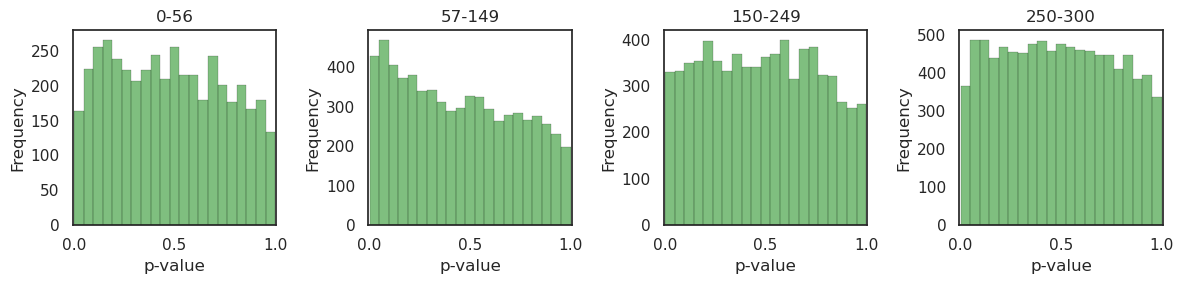

In [ ]:
fig,axes = plt.subplots(1,len(windows),figsize=(3*len(windows), 3))
for idx in range(len(windows)):

    # every link that has a p-value of 1 in GC, put a p-value of 1 also in TE
    granger_causalities_p_values[idx][granger_causalities_p_values[idx] == 1.0] = np.nan
    # p_values_list[idx][granger_causalities_p_values[idx] == 1.0] = np.nan

    ax = axes.flatten()[idx]
    # ax.hist(p_values_list[idx].flatten(), bins = int(51), alpha=0.5, edgecolor='black', linewidth=0.25, color='blue', label='TE')
    granger_causality_pvalues = granger_causalities_p_values[idx].flatten()
    ax.hist(granger_causality_pvalues, bins = int(21), alpha=0.5, edgecolor='black', linewidth=0.25, color='green', label='GC')
    ax.set_xlabel('p-value')
    ax.set_ylabel('Frequency')
    # ax.legend()
    (start, end) = windows[idx]
    ax.set_title(f'{start}-{end}')
    ax.set_xlim(-0.005,1.005)
fig.set_tight_layout(True)
# fig.savefig(f'./plots_notes/p_values_GG.png', dpi=300)

In [15]:
# find out which species have the lowest p value
p_values = granger_causalities_p_values[0] # a numpy matrix of the pairs of species and the p-value of their granger causality

# find the pair with the lowest p-value
# create a dataframe with all the pairs of species and their p-values
rows = []
for i in range(p_values.shape[0]):
    for j in range(p_values.shape[1]):
        if not np.isnan(p_values[i, j]):
            row = {'species_1': species_index_T[i], 'species_2': species_index_T[j], 'p_value': p_values[i, j]}
            rows.append(row)

p_values_df = pd.DataFrame(rows)
p_values_df = p_values_df.sort_values(by='p_value', ascending=True)
p_values_df

species_1         species_2  p_value
905            Fagus            Galium    0.000
3351  Trifolium type          Apiaceae    0.000
3722      Urticaceae           Rhamnus    0.001
4791        Apiaceae         Rubiaceae    0.002
4696          Galium             Fagus    0.003
...              ...               ...      ...
4030     Primulaceae        Lotus type    0.998
3659       Lamiaceae  Ephedra fragilis    0.999
3387        Rosaceae         Artemisia    0.999
618            Ulmus           Papaver    0.999
3255      Lotus type          Plantago    0.999

[4963 rows x 3 columns]

In [16]:
# draw the abundances of Galium and Fagus
fig, ax = plt.subplots(figsize=(10, 5))
idx = 20
species1, species2 = p_values_df.iloc[idx][['species_1', 'species_2']]
print(species1, species2)
print()
# ax.plot(abundances[species1]['prev_x'][0:100], abundances[species1]['prev_y'][0:100], label=species1, color='blue')
# ax.plot(abundances[species2]['prev_x'][0:100], abundances[species2]['prev_y'][0:100], label=species2, color='red')
ax.plot(abundances[species1]['x'][0:51], abundances[species1]['y'][0:51], label=species1, color='blue')
ax.plot(abundances[species2]['x'][0:51], abundances[species2]['y'][0:51], label=species2, color='red')

# ax.plot(           abundances['Taxus']['y'][0:51], label='Taxus', lw=3)
# ax.plot(   abundances['Valerianaceae']['y'][0:51], label='Valerianaceae')
# ax.plot(abundances['Ephedra fragilis']['y'][0:51], label='Ephedra fragilis')
# print(p_values_df)

ax.legend()

Scrophulariaceae Brassicaceae



## Degree distribution

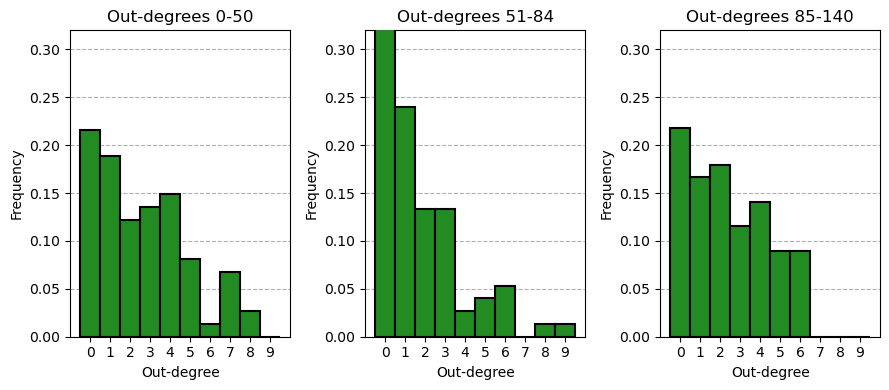

In [17]:
# calculate out-degree distributions

fig, axes = plt.subplots(1, len(windows), figsize=(3*len(windows), 4))
degree_distributions = []
for idx, graph in enumerate(graphs):
    # Only take into account nodes with abundance higher than 0

    out_degree = np.array([graphs[idx].out_degree(n) for n in graphs[idx].nodes() if (abundances[species_index_T_non_aq[n]]['y'][windows[idx][0]:windows[idx][1]].sum() > 0)])
    degree_distributions.append(out_degree)
    # plot the degree distributions
    ax = axes.flatten()[idx]
    ax.grid(axis='y', zorder=0, linestyle='--', alpha=1)
    ax.hist(out_degree, histtype='bar',
            bins=np.arange(-0.5, 10.5, 1),
            # bins=np.arange(-0.5, out_degree.max()+0.5, 1),
            density=True, zorder=3,
            edgecolor='black', linewidth=1.5, color = 'forestgreen')
    ax.set_xlabel('Out-degree')
    ax.set_ylabel('Frequency')
    (start, end) = windows[idx]
    ax.set_title(f'Out-degrees {start}-{end}')
    ax.set_ylim(0,0.32)
    ax.set_xticks(np.arange(0, 10, 1))
    ax.set_xticklabels(np.arange(0, 10, 1), rotation=0)
fig.set_tight_layout(True)
# fig.savefig(f'./{results}/cgc_out_degree_distributions_firewindows.png', dpi=300)

0.05 91
0.05 287
0.05 245
0.05 308


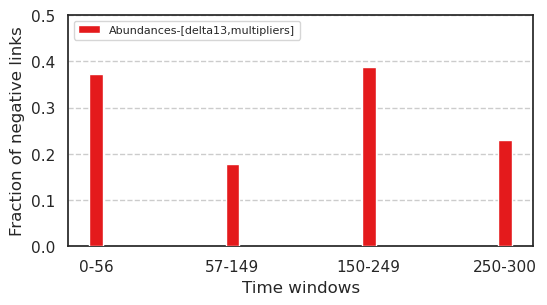

In [93]:
# make a bar plot of the percentage of negative links for each window, for different causality methods
import seaborn as sns
sns.set_theme(style="white")

fig, ax = plt.subplots(figsize=(6, 3))
width = 0.1

# set color rotation palette
colors = sns.color_palette("Set1", 4)
plt.gca().set_prop_cycle(color=colors)
labels = ['Abundances-[delta13,multipliers]']
# labels = ['Abundances-[delta13]', 'PAR-[delta13]', 'Abundances-[delta13,multipliers]', 'PAR-[delta13,multipliers]']
for i, GC_method in enumerate(['bootstrap_conditional_GC/abundances_cond2']):
# for i, GC_method in enumerate(['conditional_GC/abundances_cond1', 'conditional_GC/PAR_cond1', 'conditional_GC/abundances_cond2', 'conditional_GC/PAR_cond2']):
    granger_causalities, granger_causalities_p_values, graphs = read_GC_network(f'{GC_method}')
    # Percentage of positive and negative links
    positive_links = []
    negative_links = []
    for j, graph in enumerate(graphs):
        positive_links.append(len([e for e in graph.edges(data=True) if e[2]['weight'] > 0]) / graph.number_of_edges())
        negative_links.append(len([e for e in graph.edges(data=True) if e[2]['weight'] < 0]) / graph.number_of_edges())

    ax.bar(np.arange(len(windows)) + i*width, negative_links, width, label=labels[i], zorder=3)
ax.set_xticks(np.arange(len(windows)))
ax.set_xticklabels([f'{start}-{end}' for (start, end) in windows])
ax.set_ylabel('Fraction of negative links')
ax.set_xlabel('Time windows')
ax.set_ylim(0, 0.50)
ax.grid(axis='y', zorder=0, linestyle='--', alpha=1)
ax.legend(loc='upper left', fontsize=8)

fig.savefig(f'./plots_notes/negative_links_GG.png', dpi=300, bbox_inches='tight')

In [19]:
print(np.array(positive_links)*100)
print(np.array(negative_links)*100)

[76.6798419  59.47368421 67.82178218]
[23.3201581  40.52631579 32.17821782]


## Individual temporalities of nodes

253 190
1 - Temporality [0-50] -> [51-84]: 0.018   (mean random: 0.013, std: 0.008)
190 202
1 - Temporality [51-84] -> [85-140]: 0.018   (mean random: 0.013, std: 0.009)


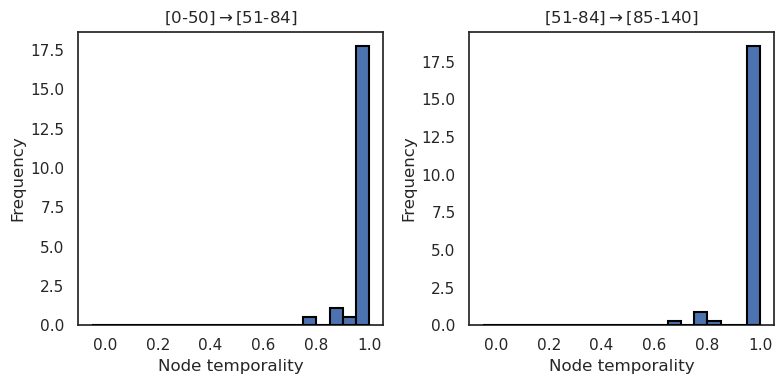

In [20]:
# individual temporalities of nodes
fig, axes = plt.subplots(1, len(windows)-1, figsize=(4*(len(windows)-1),4), layout='tight')

temporalities = pd.DataFrame(index = [species_index_T_non_aq[node] for node in graphs[idx].nodes()])
for i in range(0,len(graphs)-1):
    edg1 = set(graphs[i].edges)
    edg2 = set(graphs[i+1].edges)
    # edge temporality for each node: make a histogram of the number of edges that are present in both graphs for each node
    node_temporality = []
    for node in graphs[i].nodes():
        edg1_node = set(graphs[i].edges(node))
        edg2_node = set(graphs[i+1].edges(node))
        if len(edg1_node | edg2_node) != 0: 
            node_temporality.append(1 - len(edg1_node & edg2_node) / len(edg1_node | edg2_node))
        else:
            node_temporality.append(np.nan)

    # temporalities[i] = [node_temporality[i] for i, node in enumerate(graphs[idx].nodes())]
    
    # plot the histogram of node_temporality
    ax = axes.flatten()[i]
    ax.hist(node_temporality, bins=np.arange(-0.05, 1.05, 0.05), density=True,
            edgecolor='black', linewidth=1.5, histtype='bar', zorder=3)
    ax.set_xlabel('Node temporality')
    ax.set_ylabel('Frequency')
    ax.set_title(f'[{windows[i][0]}-{windows[i][1]}]' + r'$\rightarrow$' + f'[{windows[i+1][0]}-{windows[i+1][1]}]')

    #network temporality
    temporality = 1. - (1. - len(edg1 & edg2) / len(edg1 | edg2))

    # compare with random graphs

    random_temporalities = np.zeros(100)  # Store temporality for 100 iterations
    n = graphs[i].number_of_nodes()
    l1 = graphs[i].number_of_edges()
    l2 = graphs[i+1].number_of_edges()
    print(l1, l2)
    for t in range(len(temporalities)):
        g1 = nx.gnm_random_graph(n, l1, directed=True)
        g2 = nx.gnm_random_graph(n, l2, directed=True)
        # calculate the temporality of the random graphs
        edg1 = set(g1.edges)
        edg2 = set(g2.edges)
        random_temporality = 1. - (1. - len(edg1 & edg2) / len(edg1 | edg2))
        random_temporalities[t] = random_temporality

    print(f'1 - Temporality [{windows[i][0]}-{windows[i][1]}] -> [{windows[i+1][0]}-{windows[i+1][1]}]: {temporality:.3f}' + 
          f'   (mean random: {random_temporalities.mean():.3f}, std: {random_temporalities.std():.3f})')

# fig.savefig(f'./{results}/node_temporality_firewinkdows.png', dpi=300, bbox_inches='tight')

## Eigenvector centrality

In [21]:
from scipy.sparse.csgraph import laplacian
from scipy.linalg import eig
centralities = pd.DataFrame(index=[species_index_T_non_aq[node] for node in graphs[0].nodes()])
for idx,G in enumerate(graphs):
    centralities[idx] = nx.eigenvector_centrality(G.reverse(), max_iter=1000).values()
    # pd.Series(centralities[i].values(), index=[species_index_T_non_aq[node] for node in G.nodes()]).sort_values(ascending=False).head(20)
centralities['sum'] = centralities.sum(axis=1)

In [22]:
centralities.sort_values(by='sum', ascending=False).to_csv(f'./{results}/centralities_firewindows.csv', sep='|', index=True)

### Correlation between eigenvector centralities across windows

In [23]:
import seaborn as sns
corr_matrix = centralities.drop(columns=['sum']).corr(method='pearson')
sns.heatmap(corr_matrix, annot=True, cmap='seismic_r', center=0)


<Axes: >

## Distances between graphs (windows)

In [24]:
import networkx as nx
from collections import Counter
import hashlib

def weisfeiler_lehman_kernel(g1, g2, h=2):
    def initial_labeling(graph):
        return {node: str(graph.degree[node]) for node in graph.nodes()}
    
    def aggregate_labels(graph, labels):
        new_labels = {}
        for node in graph.nodes():
            neighbor_labels = sorted(labels[neighbor] for neighbor in graph.neighbors(node))
            long_label = labels[node] + "_" + "_".join(neighbor_labels)
            # Hash the label for uniqueness
            new_labels[node] = hashlib.md5(long_label.encode()).hexdigest()
        return new_labels

    def label_histogram(graph, h):
        labels = initial_labeling(graph)
        hist = Counter(labels.values())
        
        for i in range(h):
            labels = aggregate_labels(graph, labels)
            hist.update(labels.values())
        
        return hist

    hist1 = label_histogram(g1, h)
    hist2 = label_histogram(g2, h)

    # Compute kernel value as inner product (can also use other distances)
    kernel_value = sum(hist1[label] * hist2[label] for label in set(hist1) | set(hist2))
    return kernel_value

for idx in range(len(graphs)-1):
    similarity = weisfeiler_lehman_kernel(graphs[idx], graphs[idx+1], h=3)
    print(f"{windows[idx][0]}-{windows[idx][1]} to {windows[idx+1][0]}-{windows[idx+1][1]} similarity: {similarity:.3f}")

# similarity between similar random graphs
import random
def generate_random_graph(num_nodes, num_edges):
    G = nx.gnm_random_graph(num_nodes, num_edges, directed=True)
    return G

idx = 1
num_nodes = graphs[idx].number_of_nodes()
num_edges1 = graphs[idx].number_of_edges()
num_edges2 = graphs[idx+1].number_of_edges()
random_graphs1 = [generate_random_graph(num_nodes, num_edges1) for _ in range(10)]
random_graphs2 = [generate_random_graph(num_nodes, num_edges2) for _ in range(10)]
similarities = []

for idx in range(len(random_graphs1)):
    similarity = weisfeiler_lehman_kernel(random_graphs1[idx], random_graphs2[idx], h=3)
    similarities.append(similarity)
print(f"Average similarity between random graphs: {np.mean(similarities):.3f} ± {np.std(similarities):.3f}")

0-50 to 51-84 similarity: 797.000
51-84 to 85-140 similarity: 797.000
Average similarity between random graphs: 833.600 ± 49.403


In [94]:
import graph_tool.all as gt
import matplotlib.colors as mcolors

# Function that returns a generator for sequential colormap colors
def sequential_color_generator(cmap_name='tab10'):
    cmap = plt.get_cmap(cmap_name)
    index = 0
    while True:
        yield cmap(index % cmap.N)
        index += 1
def sequential_custom_generator():
    colors_list = ['forestgreen', 'royalblue', 'crimson', 'grey']
    index = 0
    while True:
        yield mcolors.to_rgb(colors_list[index % len(colors_list)])
        index += 1

# Create a graph-tool Graph object from the networkx graph
def SFDP_layout(network):
    g = gt.Graph(directed=True)
    weight = g.new_edge_property("double")
    vlist = {}
    for node in network.nodes:
        #add vertex with the same index as in networkx (example: '32848242')
        vlist[node] = g.add_vertex()
        
    for edge in network.edges:
        e = g.add_edge(vlist[edge[0]], vlist[edge[1]])
        if network.edges[edge]['weight'] >= 0:
            weight[e] = np.sqrt(network.edges[edge]['weight'])
        else:
            weight[e] = -np.sqrt(-network.edges[edge]['weight'])
    # get the maximum and minimum weights in the network
    max_weight_norm = max(np.abs(weight.a))

    # state of graph with signed edges, refer to https://forum.skewed.de/t/assortative-structure-in-signed-networks-ppblockstate-covariates/1407/2
    s_map = g.new_edge_property("int")    # For sign (0 or 1)
    y_map = g.new_edge_property("double") # For transformed magnitude
    y2_map = g.new_edge_property("double") # For transformed magnitude (arctanh)
    for e in g.edges():
        # normalize to (-1, 1) open range
        x = (weight[e] / max_weight_norm) * (1-1e-6)
        s_map[e] = 0 if x < 0 else 1
        y_map[e] = -np.log(1-abs(x))
        y2_map[e] = np.arctanh(x)

        
    state = gt.minimize_nested_blockmodel_dl(g, 
                    state_args=dict(
                                    recs=[weight],
                                    rec_types=["real-normal"]
                                    ),
                    )
    
    
    pos_gt = gt.sfdp_layout(g, groups=state.levels[0].b, gamma=0.05)
    print(state)
    pos = {}
    groups = {}
    generated_colors = {}
    color_gen = sequential_custom_generator()

    for key, value in vlist.items():
        pos[key] = pos_gt[value]
        groups[key] = state.levels[0].b[value]
    for group in set(groups.values()):
        # next(color_gen)
        generated_colors[group] = next(color_gen) # np.random.rand(3,)
        # for i in range(2):
        #     next(color_gen)
    colors = [generated_colors[groups[node]] for node in network.nodes]
    widths = [np.abs(network.edges[edge]['weight']) for edge in network.edges]
    return pos, colors, state, widths

In [95]:

def custom_seismic():
    # Colors: red -> gray -> blue
    colors = [
        (0.0, 'red'),
        (0.49, 'red'),
        (0.5, 'gray'),
        (0.51, 'blue'),
        (1.0, 'blue')
    ]
    return LinearSegmentedColormap.from_list('custom_seismic_gray', colors)

In [96]:
# for every edge in the graph, calculate the correlation between the abundances of the two species
def get_correlation_edges(graph, abundances):
    correlations_edges = []
    for edge in graph.edges:
        species1 = species_index_T[edge[0]]
        species2 = species_index_T[edge[1]]
        abundance1 = abundances[species1]['y']
        abundance2 = abundances[species2]['y']
        correlation = np.corrcoef(abundance1, abundance2)[0, 1]
        correlations_edges.append(correlation)
    correlation_edges = np.array(correlations_edges)
    return correlation_edges

def get_edge_colors_and_widths(graph : nx.DiGraph, abundances, p_values):

    weight_edges = get_correlation_edges(graph, abundances)
    # used for coloring the edges: blue if positive correlation, red if negative
    def get_edge_color(correlation):
        if correlation > 0: return 'blue'
        else: return 'red'
    edge_colors = [get_edge_color(correlation) for correlation in weight_edges]
    edge_colors = [custom_seismic()((correlation+1)/2) for correlation in weight_edges]
    edge_widths = []
    for edge in graph.edges:
        p_value = p_values[edge[0], edge[1]]
        # edge_widths.append(1 / (p_value + 0.01)**(0.25))
        edge_widths.append()
    edge_widths = np.array(edge_widths)
    return edge_colors, edge_widths

In [97]:
# add many graphs together as one
big_graph = nx.DiGraph()
for idx, graph in enumerate(graphs):
    big_graph = nx.compose(big_graph, graph)

In [98]:
pos, colors, state, widths = SFDP_layout(big_graph)

<NestedBlockState object, with base <BlockState object with 83 blocks (4 nonempty), degree-corrected, with 1 edge covariate, for graph <Graph object, directed, with 83 vertices and 892 edges, at 0x7fbcf02e3310>, at 0x7fbcf0288890>, and 8 levels of sizes [(83, 4), (4, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7fbcf01fec10>


<NestedBlockState object, with base <BlockState object with 83 blocks (2 nonempty), degree-corrected, with 1 edge covariate, for graph <Graph object, directed, with 83 vertices and 91 edges, at 0x7fbcf04eebd0>, at 0x7fbd39031f50>, and 8 levels of sizes [(83, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7fbd38f97ad0>
<NestedBlockState object, with base <BlockState object with 80 blocks (3 nonempty), degree-corrected, with 1 edge covariate, for graph <Graph object, directed, with 80 vertices and 287 edges, at 0x7fbcf01dadd0>, at 0x7fbcd87d9110>, and 8 levels of sizes [(80, 3), (3, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7fbcf01ae7d0>
<NestedBlockState object, with base <BlockState object with 83 blocks (3 nonempty), degree-corrected, with 1 edge covariate, for graph <Graph object, directed, with 83 vertices and 245 edges, at 0x7fbcd86e6190>, at 0x7fbcf01dff90>, and 8 levels of sizes [(83, 3), (3, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 

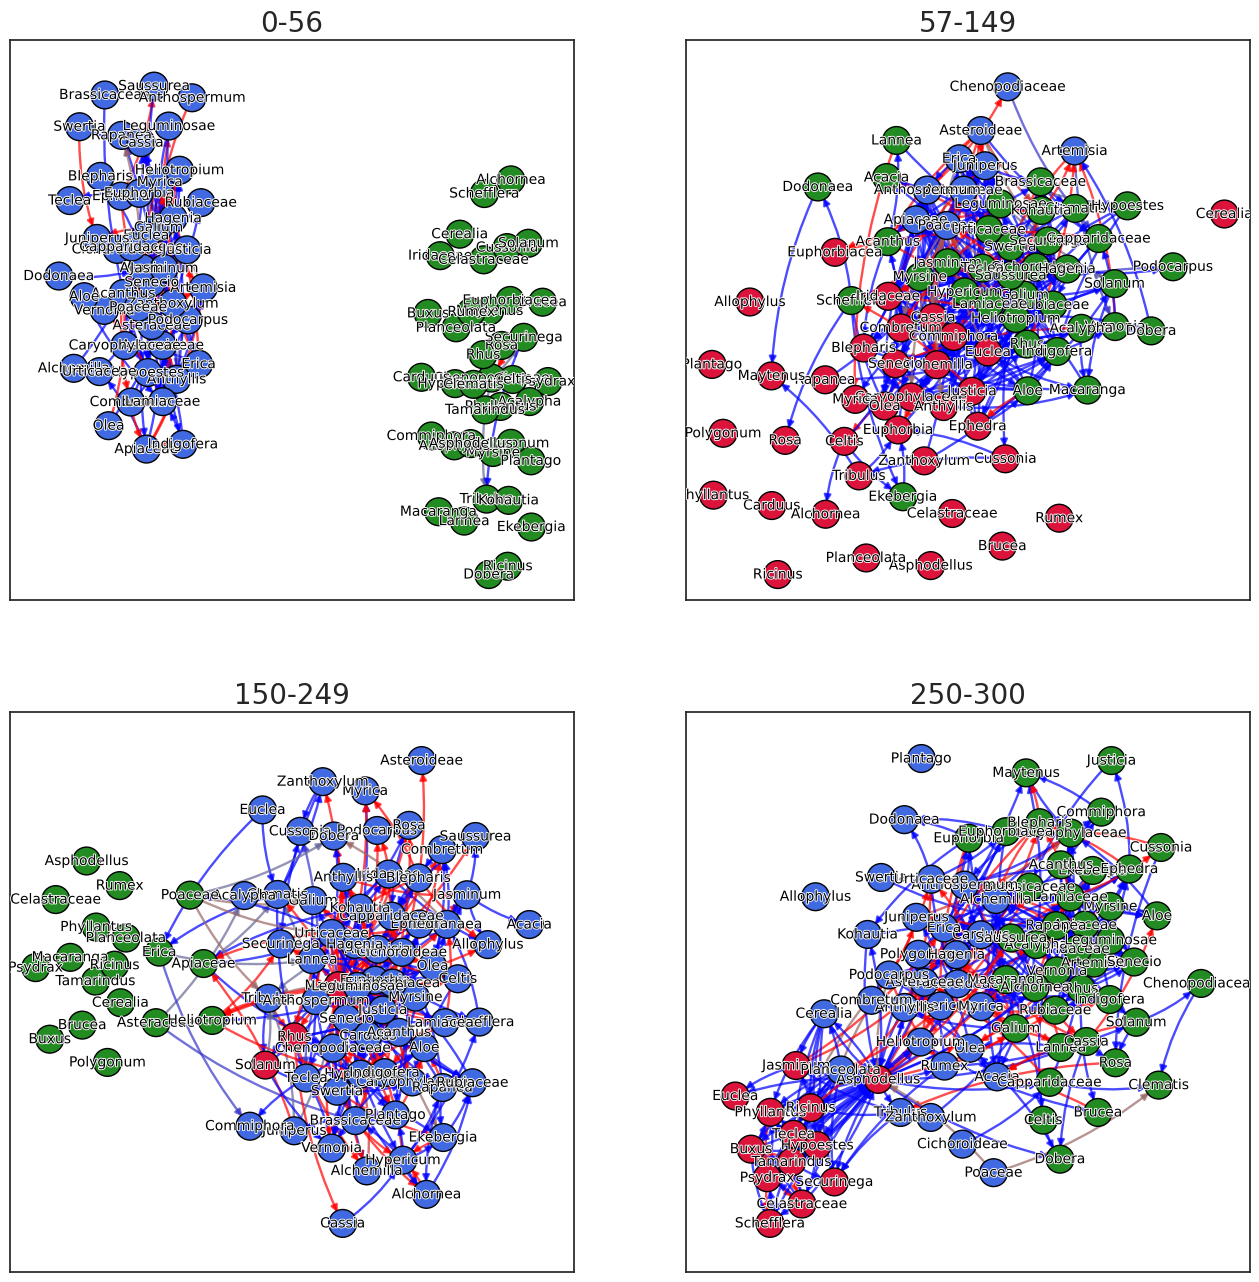

In [ ]:
# select graph for visualization
# fig, axes = plt.subplots(1,3, figsize=(24,8))
fig, axes = plt.subplots(2,2, figsize=(16,16))

for idx, graph_original in enumerate(graphs):
    (start, end) = windows[idx]
    graph = graph_original.copy()
    # remove nodes that have abundance of 0 in the current window
    nodes_to_delete = []
    for node in graph.nodes():
        if abundances[species_index_T_non_aq[node]]['y'][start:end].sum() == 0:
            nodes_to_delete.append(node)
    graph.remove_nodes_from(nodes_to_delete)
    # remove the nodes from species_index_T_non_aq
    species_index_T_non_aq_abundances = {k: v for k, v in species_index_T_non_aq.items() if k not in nodes_to_delete}

    ax = axes.flatten()[idx]
    ax.set_title(f'{start}-{end}', fontsize=20)
    granger_causality_p_values = granger_causalities_p_values[idx]


    pos, colors, state, edge_widths = SFDP_layout(graph)

    dict_abundances = {x:abundances[x]['y'].sum() for x in abundances.columns}
    sizes = [dict_abundances[species_index_T_non_aq[x]] for x in graph.nodes]

    # edge_colors, edge_widths = get_edge_colors_and_widths(graph, abundances, granger_causality_p_values)
    edge_colors = [granger_causalities[idx][u,v] for u, v in graph.edges()]
    edge_colors = [custom_seismic()((causality+1)/2) for causality in edge_colors]


    # size of the abundances
    # nx.draw_networkx_nodes(graph, ax = ax, node_size=[np.sqrt(size)*150 for size in sizes], node_color='grey', pos=pos, edgecolors='black', linewidths=1, alpha=1)
    # constant size and color of the group
    nx.draw_networkx_nodes(graph, ax = ax, node_size=400, node_color=colors, pos=pos, edgecolors='black', linewidths=1, alpha=1)

    nx.draw_networkx_edges(graph, ax = ax, alpha = 0.7, pos=pos, width=1.7, edge_color = edge_colors, connectionstyle='arc3,rad=0.1') #edge_color=edge_colors)

    texts = nx.draw_networkx_labels(graph, ax = ax, font_size=10, labels=species_index_T_non_aq_abundances,
                            pos=pos, font_color='black', font_family='sans-serif');

    for text in texts.values():
        text.set_path_effects([path_effects.Stroke(linewidth=1.3, foreground='white'),
                        path_effects.Normal()])


In [101]:
# fig.savefig(f'{results}/conditional_gc_networks/fire_windows/conditional_gc_networks.png', dpi=200, bbox_inches='tight')
fig.savefig(f'./plots_notes/gc_networks_GG.png', dpi=300, bbox_inches='tight')

In [26]:
# save fig to pickle
import pickle
with open(f'{results}/conditional_gc_networks/fire_windows/gc_networks.pickle', 'wb') as f:
    pickle.dump(fig, f)
# save the axes to pickle
with open(f'{results}/conditional_gc_networks/fire_windows/gc_networks_axes.pickle', 'wb') as f:
    pickle.dump(axes, f)

# Matrix representation

/tmp/ipykernel_61617/487283029.py:38: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(D, method='average')
/tmp/ipykernel_61617/487283029.py:39: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_opt = optimal_leaf_ordering(Z, D)


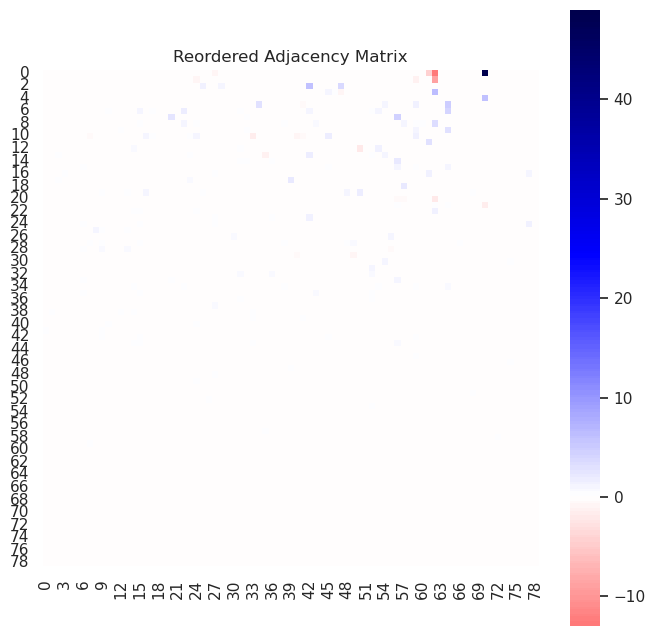

In [73]:
import networkx as nx
import numpy as np
from scipy.sparse.csgraph import laplacian
from scipy.linalg import eig

G = graphs[0]
A = nx.to_numpy_array(G)
# the original graph has the species as indices, so we create a new one
G = nx.from_numpy_array(A, create_using=nx.DiGraph)

# A = np.abs(A)

#---------------------------------------------------------------------------------
# Compute Laplacian and its eigenvectors
# L = laplacian(np.abs(A), normed=True)
# _, vecs = eig(L)
# # Get the Fiedler vector (2nd smallest eigenvalue)
# fiedler_vector = np.real(vecs[:, 1])
# # Reorder the adjacency matrix based on the Fiedler vector
# reordered_indices = np.argsort(fiedler_vector)
# reordered_A = A[reordered_indices][:, reordered_indices]
#---------------------------------------------------------------------------------
# degrees = dict(G.degree())
# # degrees with weights
# degrees = np.abs(A).sum(axis=0) + np.abs(A).sum(axis=1)
# degrees = {i: degrees[i] for i in range(len(degrees))}
# # Sort nodes by degree
# sorted_nodes = sorted(degrees, key=degrees.get, reverse=True)
# reordered_A = A[np.ix_(sorted_nodes, sorted_nodes)]
#---------------------------------------------------------------------------------

# Seriation (Optimal Leaf Ordering)

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import optimal_leaf_ordering, linkage, leaves_list

D = squareform(pdist(A))
Z = linkage(D, method='average')
Z_opt = optimal_leaf_ordering(Z, D)
sorted_nodes = leaves_list(Z_opt)
reordered_A = A[np.ix_(sorted_nodes, sorted_nodes)]

#---------------------------------------------------------------------------------

# Reorder the adjacency matrix using the community structure (state variable)
# reordered_indices = pd.DataFrame({'i':np.arange(len(state.levels[0].b.a)), 'cluster':state.levels[0].b.a}).sort_values('cluster')['i'].values
# reordered_A = A[np.ix_(reordered_indices, reordered_indices)]

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
sns.heatmap(reordered_A, cmap='seismic_r', square=True, cbar=True, center=0)


plt.title("Reordered Adjacency Matrix")
plt.show()

In [28]:
pos, colors, state, widths = SFDP_layout(big_graph)
big_pos, big_t, big_tpos = state.draw()

<NestedBlockState object, with base <BlockState object with 79 blocks (4 nonempty), degree-corrected, with 1 edge covariate, for graph <Graph object, directed, with 79 vertices and 671 edges, at 0x7f3bdc457a70>, at 0x7f3bdc26d6d0>, and 8 levels of sizes [(79, 4), (4, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7f3be4246520>


In [29]:
pos, colors, state, widths = SFDP_layout(graphs[0])

<NestedBlockState object, with base <BlockState object with 79 blocks (2 nonempty), degree-corrected, with 1 edge covariate, for graph <Graph object, directed, with 79 vertices and 145 edges, at 0x7f3be17f62b0>, at 0x7f3be198ac10>, and 8 levels of sizes [(79, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7f3bf92572f0>


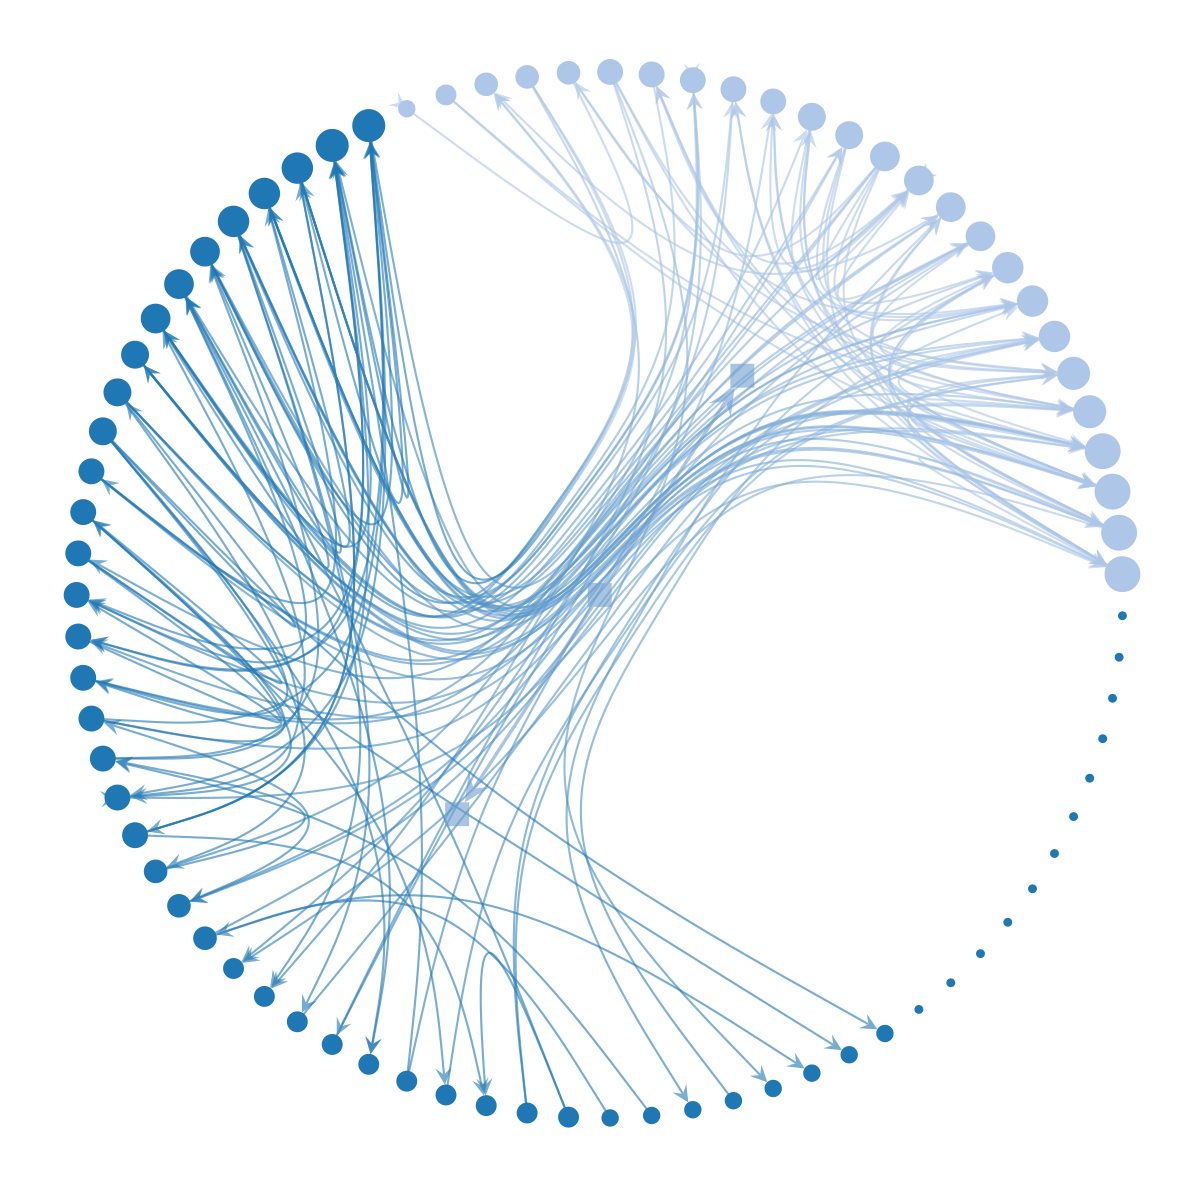

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f3be17f62b0, at 0x7f3be1804de0>,
 <GraphView object, directed, with 82 vertices and 81 edges, edges filtered by <EdgePropertyMap object with value type 'bool', for Graph 0x7f3bdc5f2850, at 0x7f3bdc4fba80>, vertices filtered by <VertexPropertyMap object with value type 'bool', for Graph 0x7f3bdc5f2850, at 0x7f3bdc4fb700>, at 0x7f3bdc5f2850>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f3bdc5f2850, at 0x7f3bdc6c5240>)

In [30]:
state.draw()

In [30]:
state.draw(pos = pos_g,
        ecmap=(matplotlib.cm.seismic, .6),
        edge_color=ecolor,
        # eorder=eweight_static,
        # edge_pen_width=gt.prop_to_size(eweight,
        #                                   1, 4,
        #                                   power=1,
        #                                   log=False),
        edge_gradient=[]);

NameError: name 'pos_g' is not defined

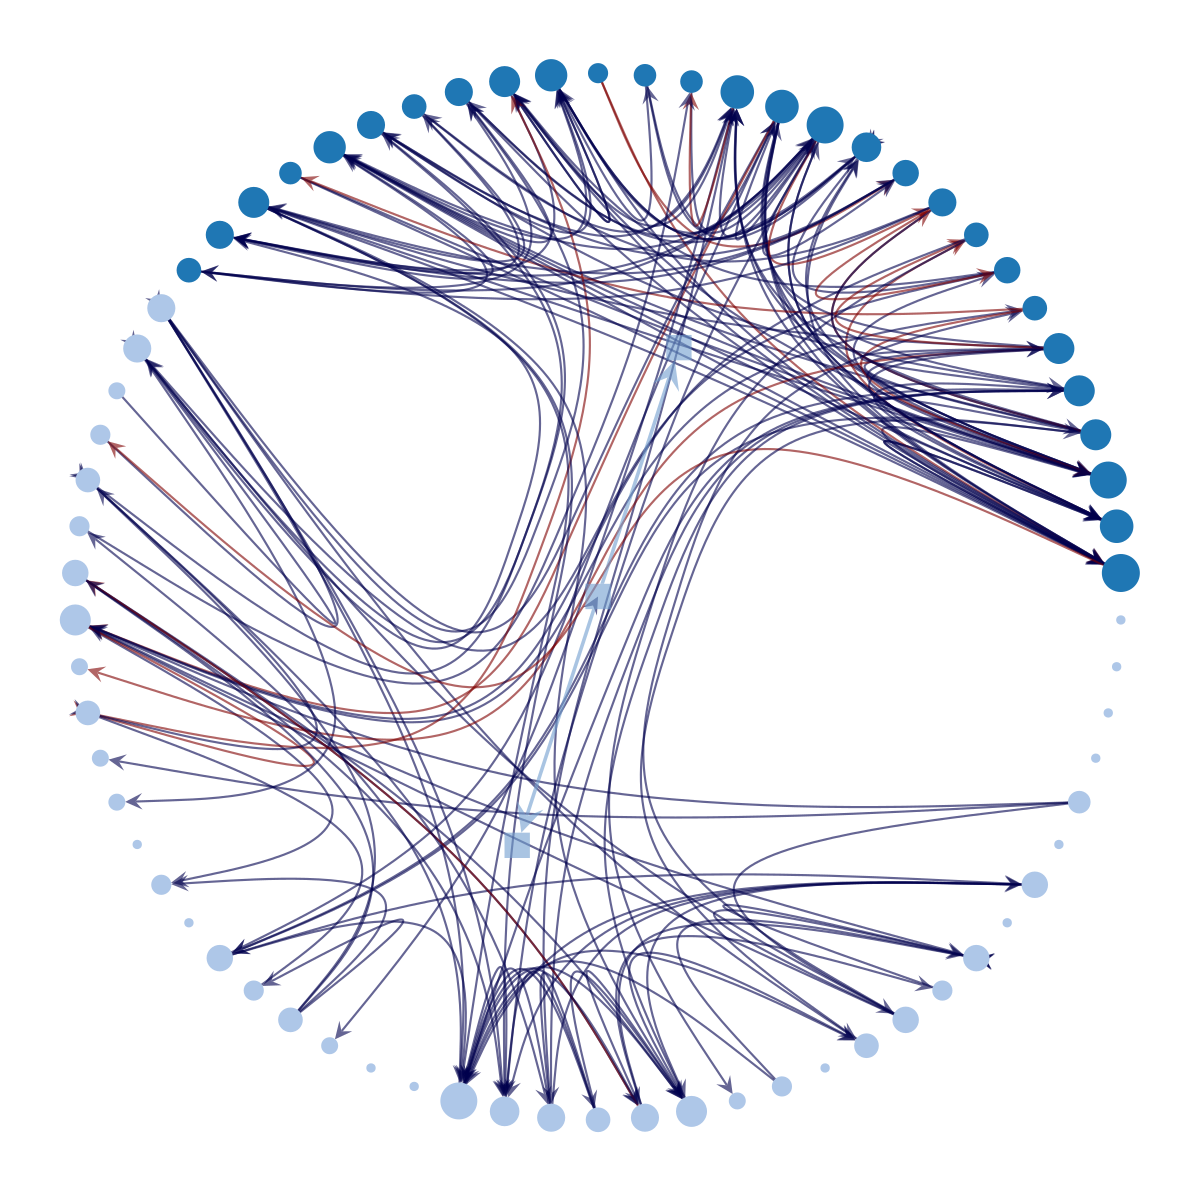

In [127]:

import graph_tool.all as gt
import matplotlib.cm
gt.seed_rng(1)

idx = 0
g = gt.Graph(directed=True, )

eweight = g.new_ep("double")
eweight_static = g.new_ep("double")

ecolor = g.new_ep("double")

vlist = {}
for node in graph.nodes:
    #add vertex with the same index as in networkx (example: '32848242')
    vlist[node] = g.add_vertex()
for edge in graphs[idx].edges:
    g.add_edge(vlist[edge[0]], vlist[edge[1]])
    eweight[g.edge(vlist[edge[0]], vlist[edge[1]])] = (granger_causalities[idx][edge[0], edge[1]])
    ecolor[g.edge(vlist[edge[0]], vlist[edge[1]])] = 0 if (granger_causalities[idx][edge[0], edge[1]] > 0) else 1


pos_g = g.new_vertex_property("vector<double>")
for v in g.vertices():
    pos_g[v] = big_pos[v]

state = gt.minimize_nested_blockmodel_dl(g)#, state_args=dict(recs=[eweight], rec_types=["real-normal"]))


# # ARGUMENTS FROM draw_hierarchy()
state.draw(pos = pos_g,
        ecmap=(matplotlib.cm.seismic, .6),
        edge_color=ecolor,
        # eorder=eweight_static,
        # edge_pen_width=gt.prop_to_size(eweight,
        #                                   1, 4,
        #                                   power=1,
        #                                   log=False),
        edge_gradient=[]);


In [120]:
state

<NestedBlockState object, with base <BlockState object with 70 blocks (2 nonempty), degree-corrected, with 1 edge covariate, for graph <Graph object, directed, with 70 vertices and 161 edges, at 0x7fee23937cf0>, at 0x7fee23984050>, and 8 levels of sizes [(70, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7fee23d04cd0>

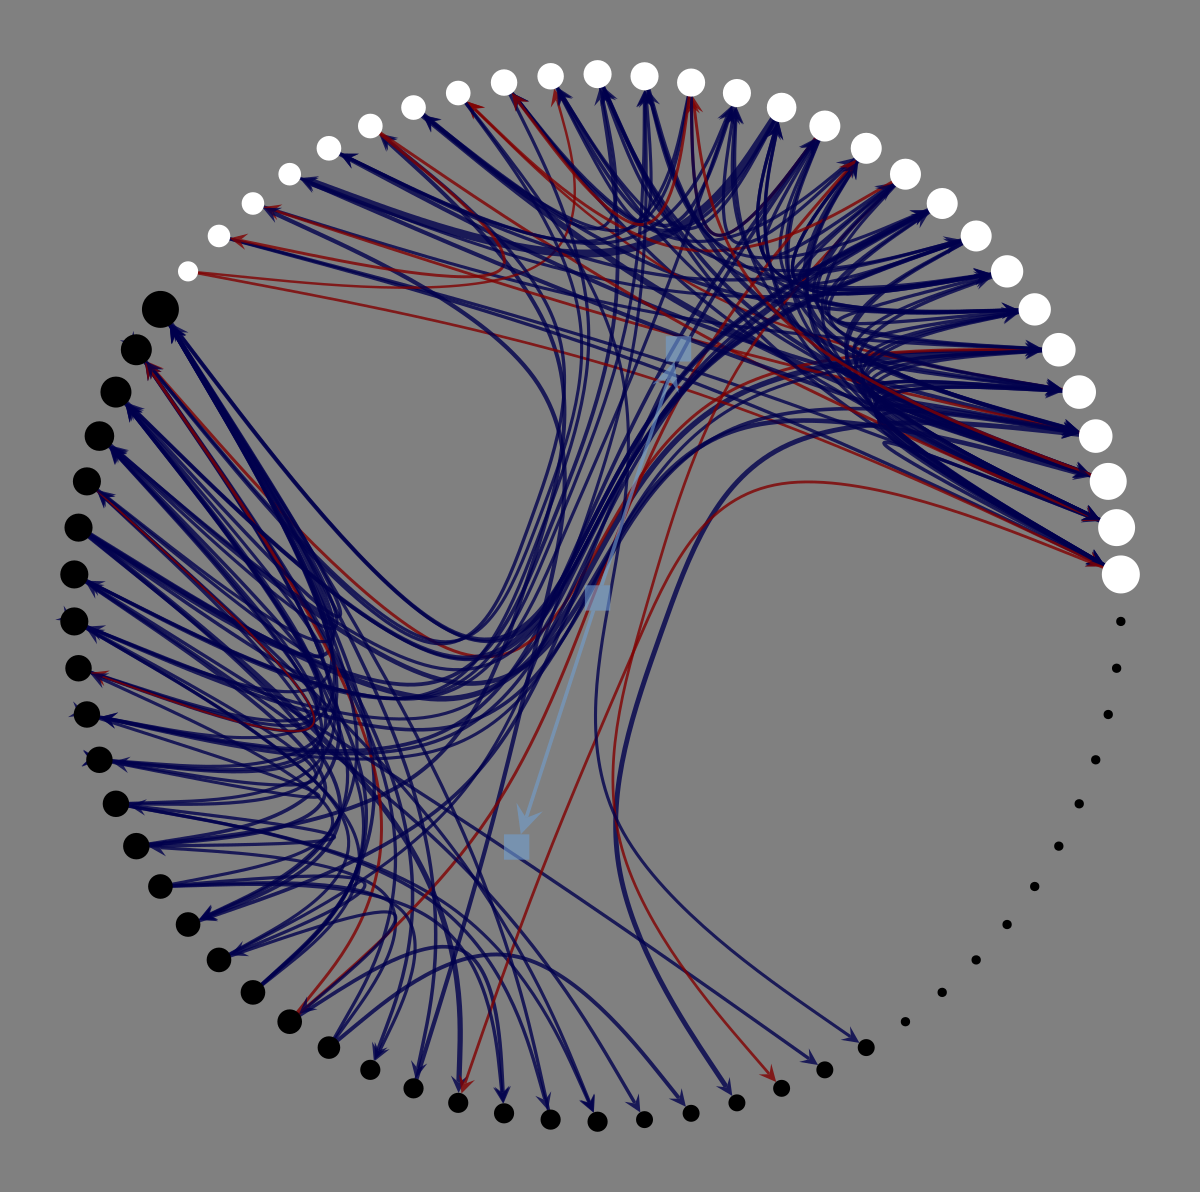

In [ ]:
gt.draw_hierarchy(state,# pos=big_pos,
                  ecmap=(matplotlib.cm.seismic, .8),
                  edge_color=ecolor,
                  edge_pen_width=gt.prop_to_size(eweight,
                                                  1, 4,
                                                  power=1,
                                                  log=False),
                    # remove hierarchy
                  hvprops=dict(alpha=1),
                  edge_gradient=[],
                  bg_color = 'grey');


In [72]:
from itertools import combinations

def is_balanced_triangle(edge_signs):
    product = edge_signs[0] * edge_signs[1] * edge_signs[2]
    return product > 0  # +1 (balanced) if positive product

def calculate_balance(graph):
    triangles = [nodes for nodes in combinations(graph.nodes, 3)
                 if graph.has_edge(nodes[0], nodes[1]) and
                    graph.has_edge(nodes[0], nodes[2]) and
                    graph.has_edge(nodes[1], nodes[2])]
    balanced_count = 0

    for u, v, w in triangles:
        edge_signs = [
            graph[u][v]['sign'],
            graph[u][w]['sign'],
            graph[v][w]['sign']
        ]
        if is_balanced_triangle(edge_signs):
            balanced_count += 1

    total_triangles = len(triangles)
    if total_triangles == 0:
        return 1.0, 0  # trivially balanced if no triangles

    return (balanced_count/total_triangles,total_triangles)

for graph in graphs:
    for u, v in graph.edges():
        # Assign a sign to each edge based on the causality value
        sign = 1 if granger_causalities[idx][u, v] > 0 else -1
        graph[u][v]['sign'] = sign

    balance, triangles = calculate_balance(graph)
    print(f"Balance ratio: {balance:.2f}, Total triangles: {triangles}")


Balance ratio: 0.83, Total triangles: 6
Balance ratio: 0.42, Total triangles: 26
Balance ratio: 0.36, Total triangles: 11
Balance ratio: 0.00, Total triangles: 69
